In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fish.util.fileio import load_image
from glob import glob
from fish.image.roi import RoiDrawing
from multiprocessing import Pool, cpu_count
%matplotlib notebook

In [176]:
base_dirs = ['/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170201/fish3/20170201_3_1_gfapGC_iGluSFR_6dpf_20170201_162355/']

In [177]:
def load_muy_mat(fname, head_name='data'):
    from h5py import File 
    data = {}
    with File(fname) as f: 
        for k in f[head_name].keys():
            data[k] = np.squeeze(f[head_name][k][:])
    return data

In [178]:
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]

paths['raw'] = paths['base'] + 'raw/'
paths['reg'] = paths['base']    
paths['ephys'] = paths['base'] + 'ephys/'
paths['rois'] = paths['base'] + 'rois/'

from os import makedirs
from os.path import exists

if not exists(paths['rois']):
    makedirs(paths['rois'])

if paths['ephys'] is not None:
    ep_dat = load_muy_mat(paths['ephys'] + 'data.mat')

fnames = glob(paths['raw'] + 'TM*')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

sample = np.squeeze(load_image(fnames[-1]))
from fish.image.vol import get_stack_freq, get_metadata

fs_im = 1 / (get_stack_freq(paths['raw'])[0] * sample.shape[0])    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))
print('Exposure : {0} ms'.format(get_metadata(paths['raw'] + 'ch0.xml')['exposure_time']))
timepoints = np.arange(0, len(fnames) * sample.shape[0])

Num raw images: 93950
Sampling rate:  950.4 Hz
Exposure : 32.0 ms


In [179]:
# get swims
from fish.ephys.ephys import estimate_onset
cam = estimate_onset(np.diff(ep_dat['frame']).clip(0,1), threshold=.1, duration=10)
swim = ep_dat['fltCh1'] + ep_dat['fltCh2']

In [180]:
# handle ROIS
#from glob import glob
#import json

#roi_file = paths['rois'] + 'rois.json'
#if exists(roi_file):
    # load rois

<IPython.core.display.Javascript object>


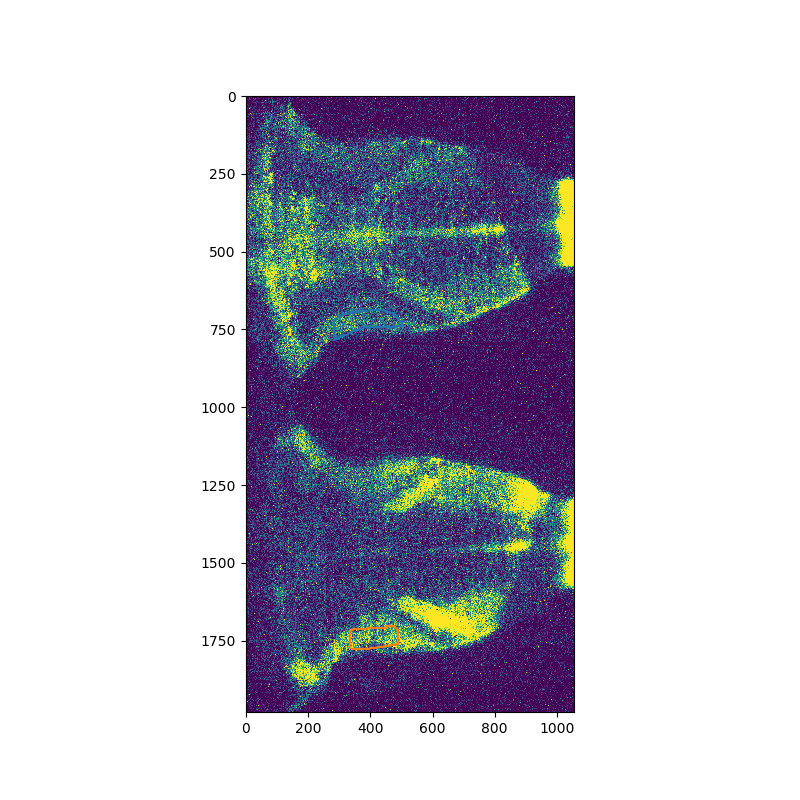

In [181]:
fig, axs = plt.subplots(figsize=(8,8))
axs.imshow(sample, clim=[100,120])
rd = RoiDrawing(axs, sample)
plt.show()

In [182]:
def h5_loader(fname, roi = None):
    from h5py import File
    with File(fname) as f:
        if roi is None:
            return f['default'].value
        else:
            return f['default'][roi]

In [183]:
masks = [r.get_mask().astype('bool') for r in rd.rois]
from skimage.measure import regionprops
bboxes = [regionprops(m.astype('int'))[0].bbox for m in masks]
roi_coords = [(slice(0, None), slice(bb[0], bb[2]), slice(bb[1], bb[3])) for bb in bboxes]

In [184]:
%%time
def get_rois(v):    
    rois = np.array([np.squeeze(h5_loader(v, r)).mean() for r in roi_coords])
    return rois

p = Pool(cpu_count())
a = np.array(p.map(get_rois, fnames))
p.close()

CPU times: user 927 ms, sys: 1.04 s, total: 1.97 s
Wall time: 6min 47s


<IPython.core.display.Javascript object>


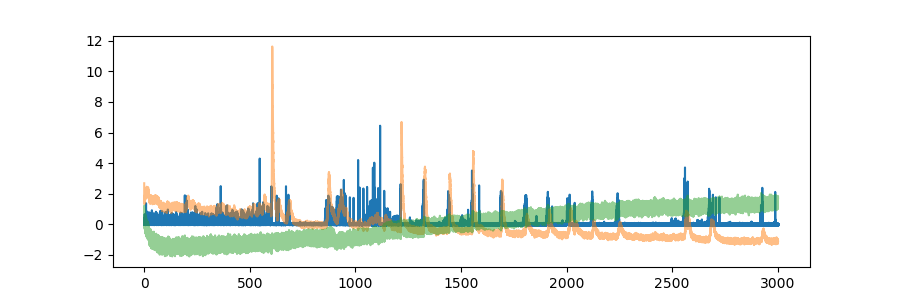

In [185]:
from scipy.stats import zscore
fig, axs = plt.subplots(figsize=(9,3))
x_axis_im = cam / 6000
x_axis_ep = np.arange(swim.shape[0]) / 6000
axs.plot(x_axis_ep, zscore(swim) * .10)
axs.plot(x_axis_im, zscore(a[:,0]), alpha=.5)
axs.plot(x_axis_im, zscore(a[:,1]), alpha=.5)


<IPython.core.display.Javascript object>


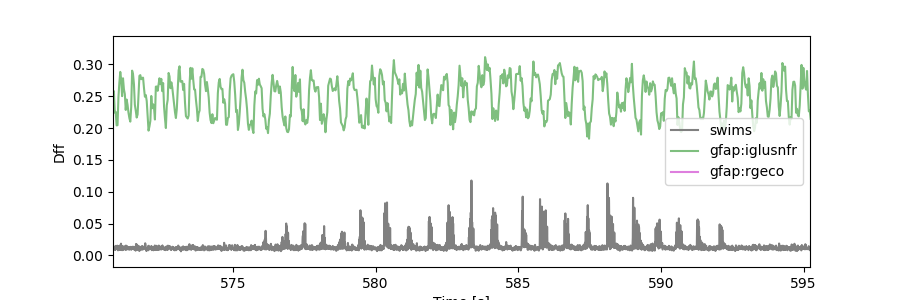

In [188]:
from fish.image.vol import dff
import pickle
dff_rgeco = dff(a[:,0] - 100, 15000, 10, .1, 20)
dff_glu = dff(a[:,1] - 100, 15000, 10, .1, 20)
fig, axs = plt.subplots(figsize=(9,3))
x_axis_im = cam / 6000
x_axis_ep = np.arange(swim.shape[0]) / 6000
offset = .2
axs.plot(x_axis_ep, swim.astype('float16') * 100, label='swims',color='gray')
axs.plot(x_axis_im, offset + dff_glu.astype('float16'), alpha=.5, label='gfap:iglusnfr',color='g')
axs.plot(x_axis_im, 2 * offset + dff_rgeco.astype('float16') , alpha=.5, label='gfap:rgeco',color='m')

axs.set_ylabel('Dff')
axs.set_xlabel('Time [s]')
axs.legend()
plt.show()
#pickle.dump(fig, open('FigureObject.fig.pickle', 'wb'))

In [168]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression(fit_intercept=False)
regr.fit(zscore(dff_rgeco).reshape(-1,1), zscore(dff_glu).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [169]:
prediction = np.squeeze(regr.predict(zscore(dff_rgeco.reshape(-1,1))))

In [170]:
np.corrcoef(zscore(dff_glu), zscore(dff_rgeco))[0,1]

0.7595744498114928

In [171]:
np.corrcoef(zscore(dff_glu) - prediction, zscore(dff_rgeco))[0,1]

-8.4721860893072157e-16

<IPython.core.display.Javascript object>


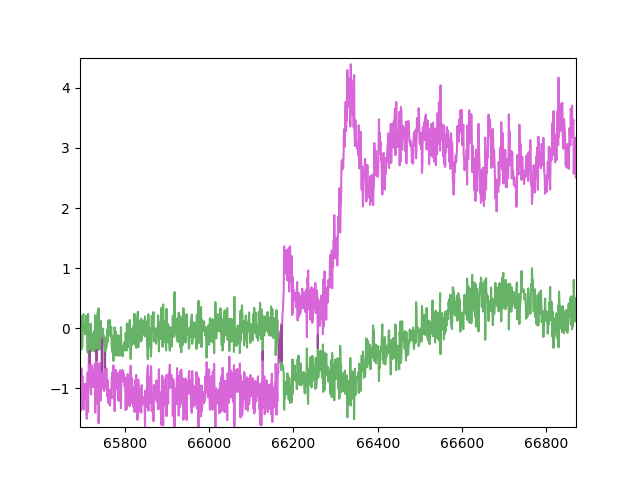

In [174]:
fig, axs = plt.subplots()

#plt.plot(zscore(dff_glu))
plt.plot(zscore(dff_glu) - prediction, alpha = .6, color='g')
#plt.plot(prediction)
plt.plot(zscore(dff_rgeco), alpha = .6, color='m')
plt.show()

<IPython.core.display.Javascript object>


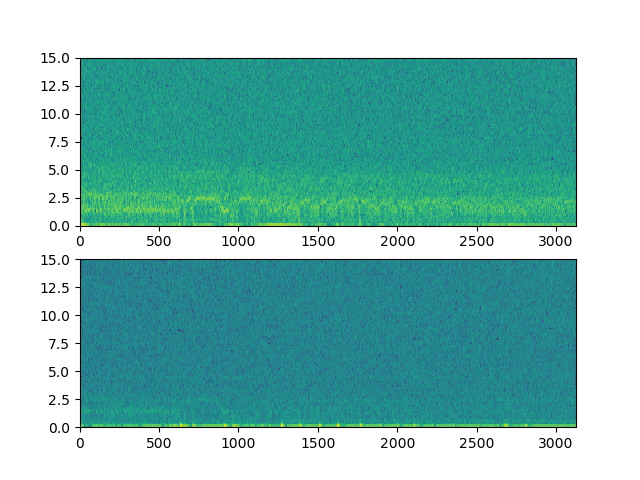

In [143]:
fig, axs = plt.subplots(nrows=2)
axs[0].specgram(zscore(dff_rgeco), Fs=30);
#axs[0].set_ylim(0, 5)
axs[1].specgram(zscore(dff_glu), Fs=30)
#axs[1].set_ylim(0, 5)
plt.show()